# Vehicle Detection

### Load Dataset

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm, grid_search
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import time

%matplotlib inline

C:\Users\deepakz\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\deepakz\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def convert(img, conv):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb' or conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV' or conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return np.copy(img)

def load_data():
    images = glob.glob('..\p5_data\**\*.png', recursive=True)
    cars = []
    non_cars = []

    for image in images:
        if 'non-vehicles' in image:
            non_cars.append(image)
        else:
            cars.append(image)
            
    return cars, non_cars

def data_look(car_list, notcar_list):

    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_non_cars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype

    return data_dict

def explore_data(cars, non_cars, data_info):

    print(data_info)

    car_image = mpimg.imread(cars[np.random.randint(0, len(cars))])
    non_car_image = mpimg.imread(non_cars[np.random.randint(0, len(non_cars))])
    
    plot_color_spaces(car_image)
    plot_color_spaces(non_car_image)

def plot_color_spaces(img):
    fig, axs = plt.subplots(6, 3, figsize=(18,9))
    axs[0][0].set_title('img')
    axs[0][0].imshow(img)
    
    axs[1][0].set_title('HSV')
    axs[1][0].imshow(convert(img, 'HSV')[:,:,0])#, cmap='gray')
    axs[1][1].set_title('HSV')
    axs[1][1].imshow(convert(img, 'HSV')[:,:,1])#, cmap='gray')
    axs[1][2].set_title('HSV')
    axs[1][2].imshow(convert(img, 'HSV')[:,:,2])#, cmap='gray')

    axs[2][0].set_title('HLS')
    axs[2][0].imshow(convert(img, 'HLS')[:,:,0])#, cmap='gray')
    axs[2][1].set_title('HLS')
    axs[2][1].imshow(convert(img, 'HLS')[:,:,1])#, cmap='gray')
    axs[2][2].set_title('HLS')
    axs[2][2].imshow(convert(img, 'HLS')[:,:,2])#, cmap='gray')

    axs[3][0].set_title('YUV')
    axs[3][0].imshow(convert(img, 'YUV')[:,:,0])#, cmap='gray')
    axs[3][1].set_title('YUV')
    axs[3][1].imshow(convert(img, 'YUV')[:,:,1])#, cmap='gray')
    axs[3][2].set_title('YUV')
    axs[3][2].imshow(convert(img, 'YUV')[:,:,2])#, cmap='gray')

    axs[4][0].set_title('YCrCb')
    axs[4][0].imshow(convert(img, 'YCrCb')[:,:,0])#, cmap='gray')
    axs[4][1].set_title('YCrCb')
    axs[4][1].imshow(convert(img, 'YCrCb')[:,:,1])#, cmap='gray')
    axs[4][2].set_title('YCrCb')
    axs[4][2].imshow(convert(img, 'YCrCb')[:,:,2])#, cmap='gray')

    axs[5][0].set_title('LUV')
    axs[5][0].imshow(convert(img, 'LUV')[:,:,0])#, cmap='gray')
    axs[5][1].set_title('LUV')
    axs[5][1].imshow(convert(img, 'LUV')[:,:,1])#, cmap='gray')
    axs[5][2].set_title('LUV')
    axs[5][2].imshow(convert(img, 'LUV')[:,:,2])#, cmap='gray')
    
    return

{'n_cars': 8792, 'data_type': dtype('float32'), 'n_non_cars': 8968, 'image_shape': (64, 64, 3)}


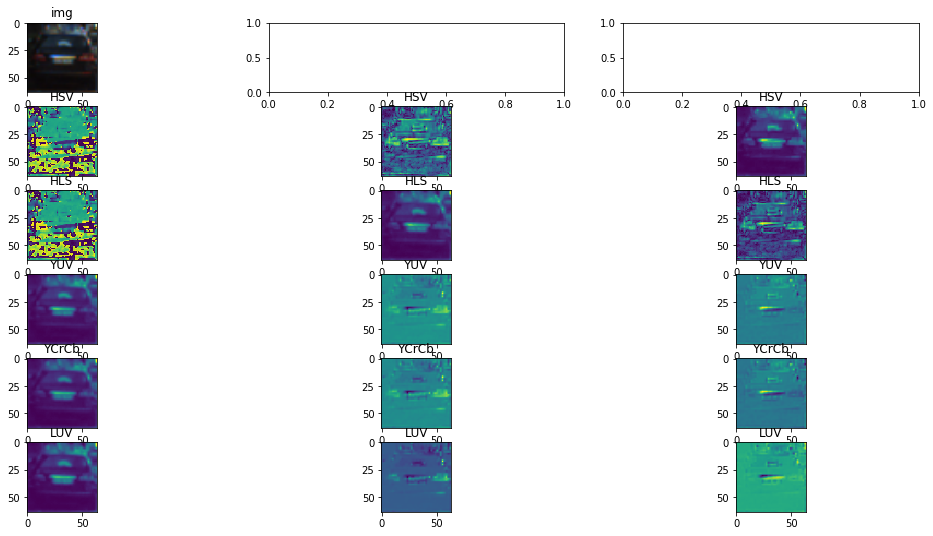

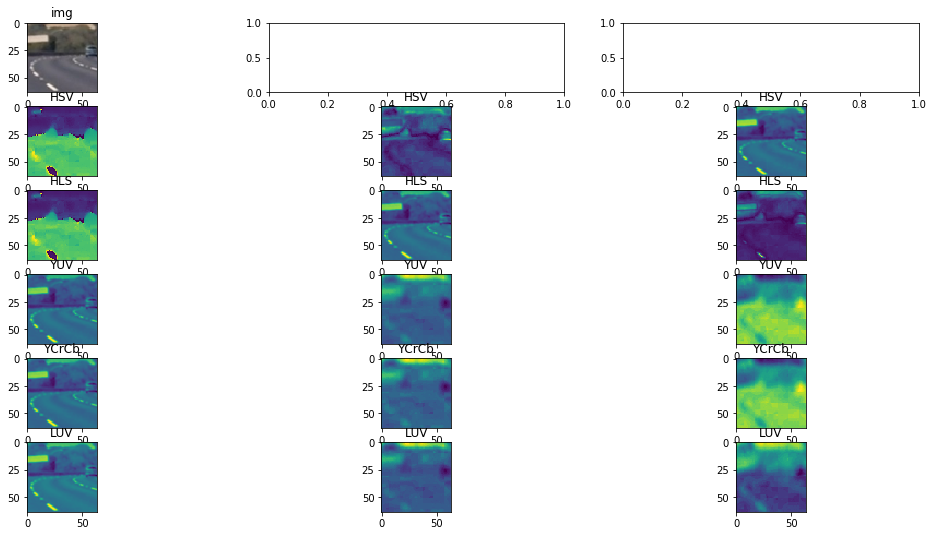

In [3]:
cars, non_cars = load_data()
data_info = data_look(cars, non_cars)
explore_data(cars, non_cars, data_info)

### Generate HOG features

In [4]:
class Feature_Extractor:
    
    def __init__(self, cspace, hog_channel, dataset_file):
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.spatial_size=(32, 32)
        self.hist_bins=32
        self.hist_range=(0, 256)

        self.hog_channel = hog_channel
        self.cspace = cspace
        self.dataset_file = dataset_file
        
        return
        
    def bin_spatial(self, img):
        color1 = cv2.resize(img[:,:,0], self.spatial_size).ravel()
        color2 = cv2.resize(img[:,:,1], self.spatial_size).ravel()
        color3 = cv2.resize(img[:,:,2], self.spatial_size).ravel()
        return np.hstack((color1, color2, color3))

    def color_hist(self, img):
        channel1_hist = np.histogram(img[:,:,0], bins=self.hist_bins, range=self.hist_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.hist_bins, range=self.hist_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.hist_bins, range=self.hist_range)

        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        
    def get_hog_features(self,
                         img,
                         orient = None,
                         pix_per_cell = None,
                         cell_per_block = None,
                         vis=False,
                         feature_vec=True):
        
        if orient is None:
            orient = self.orient
        if pix_per_cell is None:
            pix_per_cell = self.pix_per_cell
        if cell_per_block is None:
            cell_per_block = self.cell_per_block

        if vis == True:
            features, hog_image = hog(img,
                                      orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=False, 
                                      visualise=True,
                                      feature_vector=feature_vec)
            return features, hog_image
        else:      
            features = hog(img,
                           orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=False, 
                           visualise=False,
                           feature_vector=feature_vec)
            return features

    def extract_features(self, files):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in files:
            # Read in each one by one
            image = mpimg.imread(file)
            image = image.astype(np.float32)
            feature_image = convert(image, self.cspace)

            if self.hog_channel == 'ALL':
                channel_features = []
                for channel in range(feature_image.shape[2]):
                    channel_features.append(self.get_hog_features(feature_image[:,:,channel]))
                hog_features = np.hstack(channel_features)
            else:
                hog_features = self.get_hog_features(feature_image[:,:,self.hog_channel])
                            
            #spatial_features = self.bin_spatial(feature_image)
            #hist_features = self.color_hist(feature_image)
            #all_features = np.hstack((spatial_features, hist_features, hog_features))
            all_features = hog_features


            # Append the new feature vector to the features list
            features.append(all_features)
        # Return list of feature vectors
        return np.vstack(features)
    
    def get_dataset_features(self, cars, non_cars):
        
        dataset = {}
        if self.dataset_file is not None and os.path.isfile(self.dataset_file):
            d = pickle.load(open(self.dataset_file, 'rb'))
            self.X_scaler = d['X_scaler']
            return d
       
        car_features = self.extract_features(cars)
        non_car_features = self.extract_features(non_cars)
        X = np.vstack((car_features, non_car_features)).astype(np.float64)
        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
        
        dataset['X_train'] = X_train
        dataset['X_test'] = X_test
        dataset['y_train'] = y_train
        dataset['y_test'] = y_test
        dataset['X'] = scaled_X
        dataset['y'] = y
        dataset['X_scaler'] = self.X_scaler
        
        if self.dataset_file is not None:
            pickle.dump(dataset, open(self.dataset_file, 'wb'))
        
        return dataset
    
    def visualize_features(self, dataset, cars):
        
        car_ind = np.random.randint(0, len(cars))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(dataset['X'][car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
        
        return

In [5]:
hogger = Feature_Extractor(cspace = 'YCrCb', hog_channel = 'ALL', dataset_file = '../p5_data/ycrcb_all_channels.dataset')
#hogger = Feature_Extractor(cspace = 'YCrCb', hog_channel = 'ALL', dataset_file = 'ycrcb_all_channels_all_features.dataset')
#hogger = Feature_Extractor(cspace = 'YCrCb', hog_channel = 1, dataset_file = 'ycrcb_channel_1.dataset')

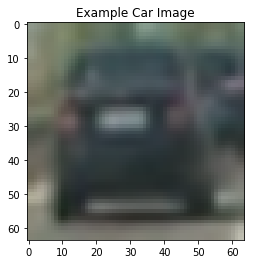

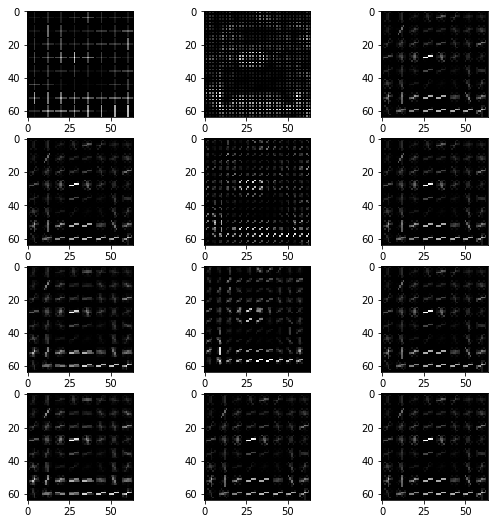

In [6]:
def test_hog(image, orient = None, pix_per_cell = None, cell_per_block = None):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    fig, axs = plt.subplots(len(orient), 3, figsize=(9,9))
    for i in range(len(orient)):
        features, hog_image = hogger.get_hog_features(gray, orient = orient[i], vis=True)
        axs[i][0].imshow(hog_image, cmap='gray')
        #axs[i][0].set_title("orient = " + str(orient[i]))

    for i in range(len(orient)):
        features, hog_image = hogger.get_hog_features(gray, pix_per_cell = pix_per_cell[i], vis=True)
        axs[i][1].imshow(hog_image, cmap='gray')
        #axs[i][1].set_title("pix_per_cell = " + str(pix_per_cell[i]))

    for i in range(len(orient)):
        features, hog_image = hogger.get_hog_features(gray, cell_per_block = cell_per_block[i], vis=True)
        axs[i][2].imshow(hog_image, cmap='gray')
        #axs[i][2].set_title("cell_per_block = " + str(cell_per_block[i]))

image = mpimg.imread(cars[2])
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
test_hog(image,
         orient = [2, 9, 60, 120],
         pix_per_cell = [2, 4, 6, 8],
         cell_per_block = [1, 2, 4, 8])
dataset = hogger.get_dataset_features(cars, non_cars)

# Train Classifier

In [7]:
def trainLinear(dataset):
    
    svc = LinearSVC()
    svc.fit(dataset['X_train'], dataset['y_train'])
    print('Test Accuracy of SVC = ', round(svc.score(dataset['X_test'], dataset['y_test']), 4))

    return svc

def train(fname, dataset = None):

    if os.path.isfile(fname):
        clf = pickle.load(open(fname, 'rb'))
    else:
        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
        svr = svm.SVC()
        #clf = RandomizedSearchCV(svr, parameters)
        clf = grid_search.GridSearchCV(svr, parameters)
        clf.fit(dataset['X_train'], dataset['y_train'])
        pickle.dump(clf, open(fname, 'wb'))
    return clf

def test(clf, dataset):
    print('Test Accuracy of model = ', round(clf.score(dataset['X_test'], dataset['y_test']), 4))
    return

#clf = trainLinear(dataset)
#clf = train('ycrcb_channel_1.model', dataset)
#clf = train('ycrcb_all_channels_all_features.model', dataset)
clf = train('../p5_data/ycrcb_all_channels.model', dataset)
test(clf, dataset)

Test Accuracy of model =  0.991


# Window Search

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hogger.get_hog_features(ch1, feature_vec=False)
    hog2 = hogger.get_hog_features(ch2, feature_vec=False)
    hog3 = hogger.get_hog_features(ch3, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = hogger.bin_spatial(subimg)
            #hist_features = hogger.color_hist(subimg)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes

In [11]:
ystart = 400
ystop = 656
scale = 1.5

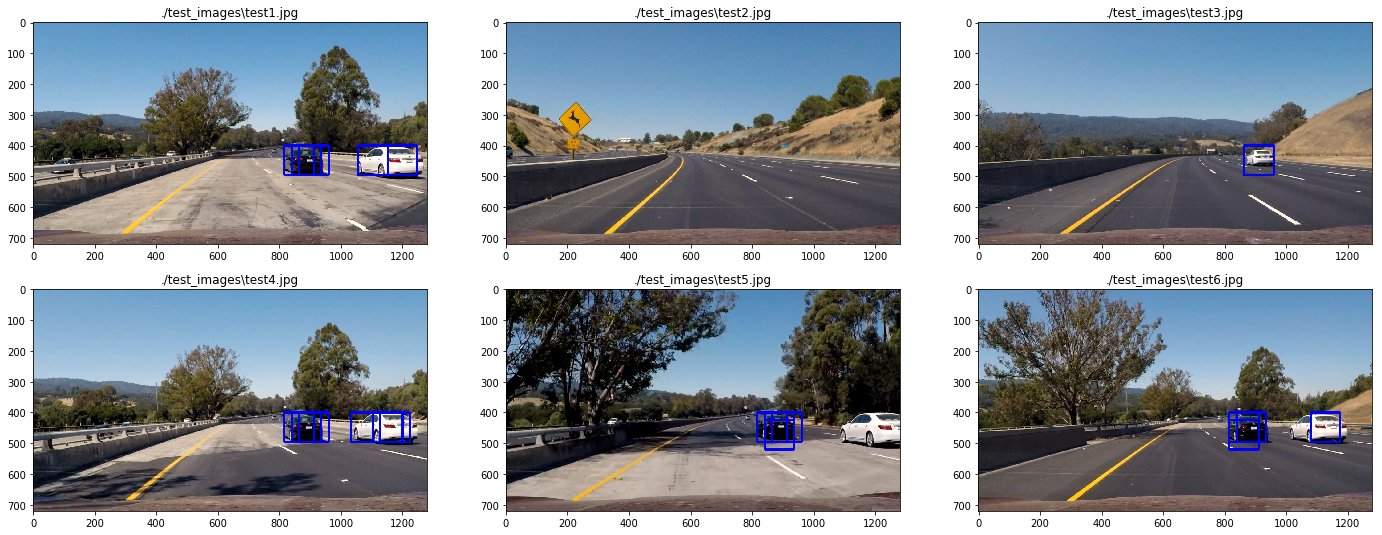

In [12]:
files = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(2, 3, figsize=(24, 9))
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    out_img, bboxes = find_cars(img,
                        ystart,
                        ystop,
                        scale,
                        clf,
                        hogger.X_scaler,
                        hogger.orient,
                        hogger.pix_per_cell,
                        hogger.cell_per_block,
                        hogger.spatial_size,
                        hogger.hist_bins)
    axs[(int)(idx / 3)][idx % 3].imshow(out_img)
    axs[(int)(idx / 3)][idx % 3].set_title(file)

### Trying out scale effect

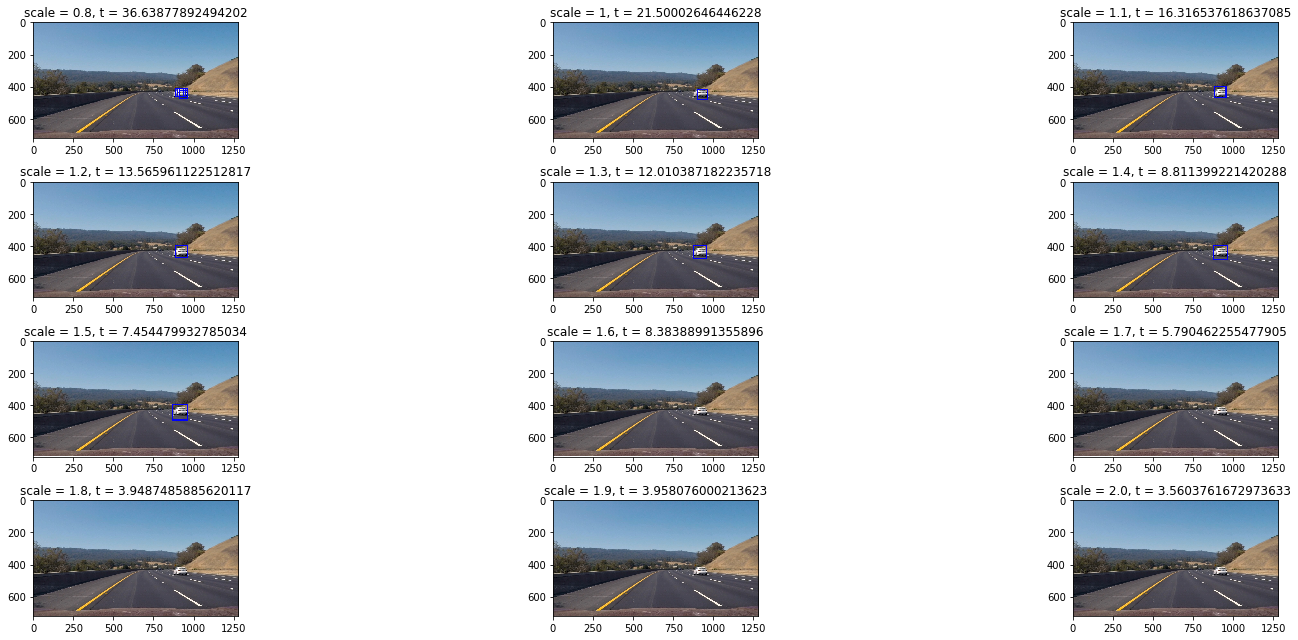

In [27]:
fig, axs = plt.subplots(4, 3, figsize=(24, 9))
img = mpimg.imread(files[2])
for idx, scale in enumerate([0.8, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]):
    t1 = time.time()
    out_img, bboxes = find_cars(img,
                        ystart,
                        ystop,
                        scale,
                        clf,
                        hogger.X_scaler,
                        hogger.orient,
                        hogger.pix_per_cell,
                        hogger.cell_per_block,
                        hogger.spatial_size,
                        hogger.hist_bins)
    t2 = time.time()
    axs[(int)(idx / 3)][idx % 3].imshow(out_img)
    axs[(int)(idx / 3)][idx % 3].set_title('scale = ' + str(scale) + ', t = ' + str(t2 - t1))
    
plt.tight_layout()

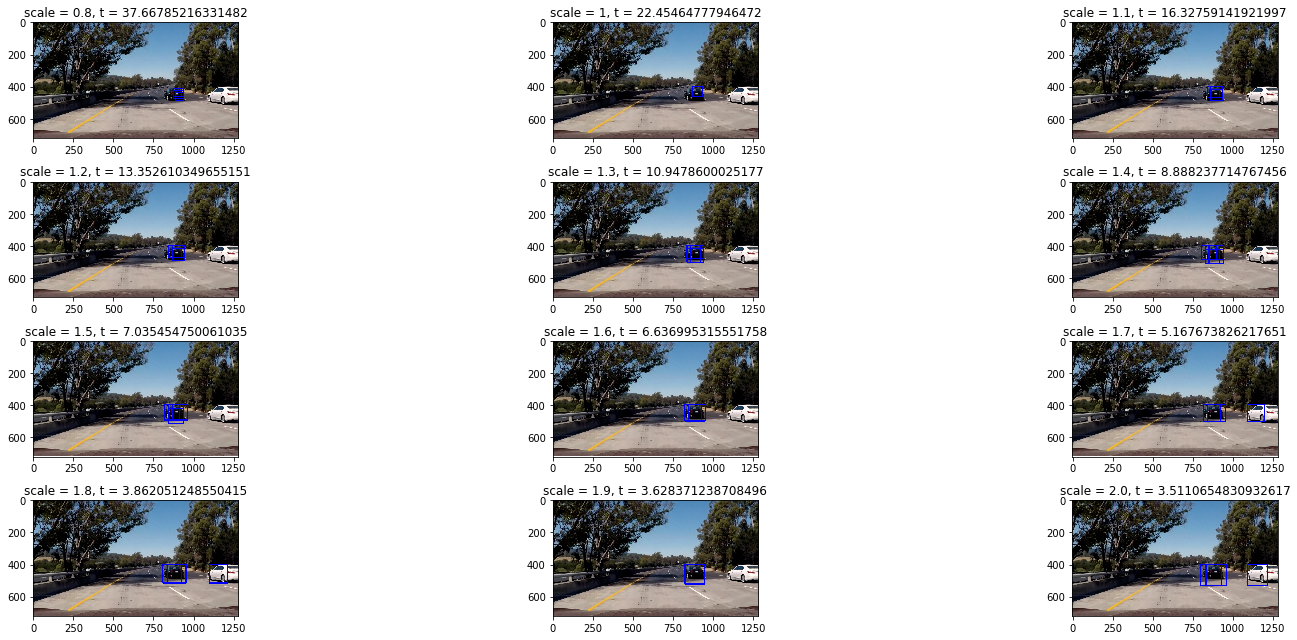

In [29]:
fig, axs = plt.subplots(4, 3, figsize=(24, 9))
img = mpimg.imread(files[4])
for idx, scale in enumerate([0.8, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]):
    t1 = time.time()
    out_img, bboxes = find_cars(img,
                        ystart,
                        ystop,
                        scale,
                        clf,
                        hogger.X_scaler,
                        hogger.orient,
                        hogger.pix_per_cell,
                        hogger.cell_per_block,
                        hogger.spatial_size,
                        hogger.hist_bins)
    t2 = time.time()
    axs[(int)(idx / 3)][idx % 3].imshow(out_img)
    axs[(int)(idx / 3)][idx % 3].set_title('scale = ' + str(scale) + ', t = ' + str(t2 - t1))

plt.tight_layout()

# Address multiple detections and false positives

In [30]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def filter_on_heat(img, bboxes, threshold = 1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(img), labels), heatmap

In [33]:
def_threshold = 1
scales = [1.4, 1,5, 1.7, 1.8]

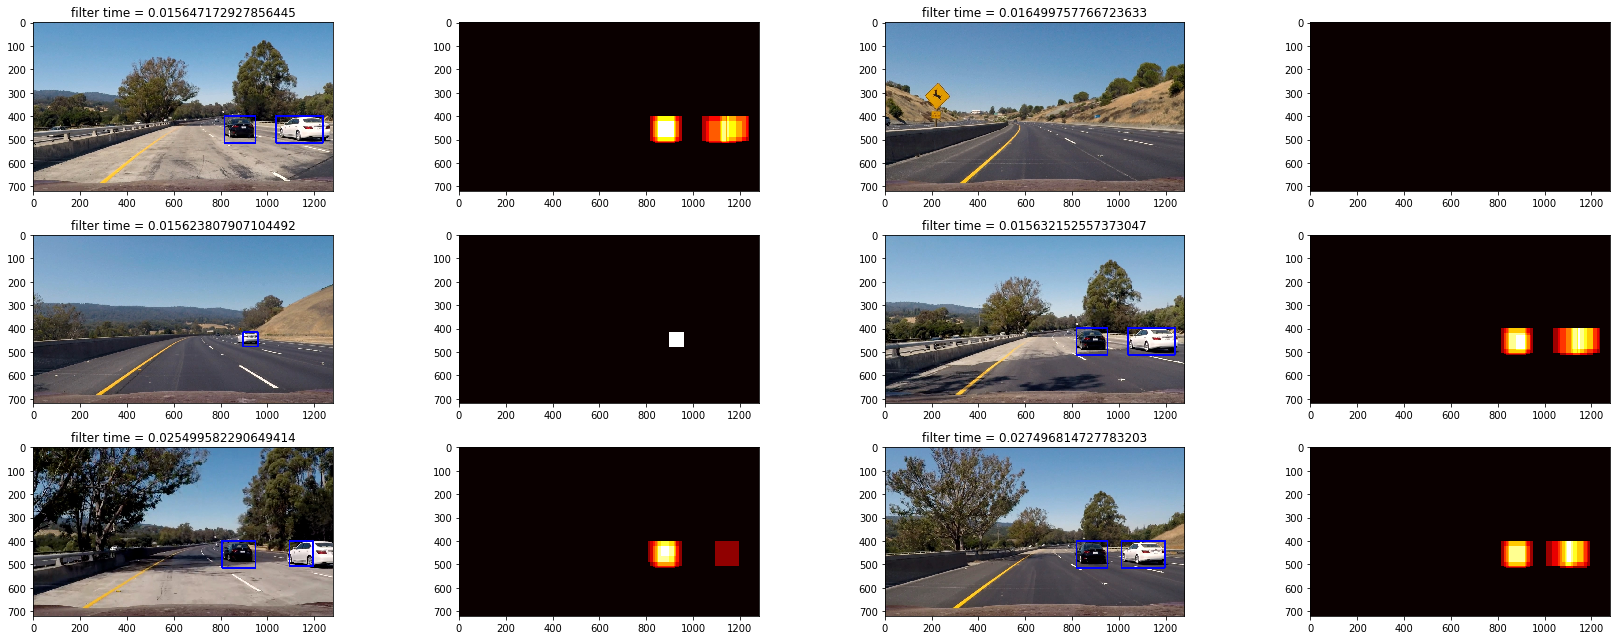

In [34]:
files = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(3, 4, figsize=(24, 9))
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    boxes = []
    for scale in scales:
        out_img, bboxes = find_cars(img,
                            ystart,
                            ystop,
                            scale,
                            clf,
                            hogger.X_scaler,
                            hogger.orient,
                            hogger.pix_per_cell,
                            hogger.cell_per_block,
                            hogger.spatial_size,
                            hogger.hist_bins)
        boxes += bboxes
    t1 = time.time()
    out_img, heatmap = filter_on_heat(img, boxes, threshold = def_threshold)
    t2 = time.time()
    axs[(int)(idx / 2)][(idx % 2) * 2].imshow(out_img)
    axs[(int)(idx / 2)][(idx % 2) * 2].set_title('filter time = ' + str(t2 - t1))
    axs[(int)(idx / 2)][(idx % 2) * 2 + 1].imshow(heatmap, cmap='hot')

plt.tight_layout()

# Pipeline

In [ ]:
def pipeline(img):
    
    boxes = []
    for scale in scales:
        out_img, bboxes = find_cars(img,
                            ystart,
                            ystop,
                            scale,
                            clf,
                            hogger.X_scaler,
                            hogger.orient,
                            hogger.pix_per_cell,
                            hogger.cell_per_block,
                            hogger.spatial_size,
                            hogger.hist_bins)
        boxes += bboxes
    out_img, heatmap = filter_on_heat(img, boxes, threshold = def_threshold)
    return out_img    

In [ ]:
def testOnVideo(inFile, outFile):
    testClip = VideoFileClip(inFile)
    result = testClip.fl_image(pipeline)
    %time result.write_videofile(outFile, audio=False)
    testClip.reader.close()
    testClip.audio.reader.close_proc()

testOnVideo('./project_video.mp4', './project_video_result.mp4')